<h2><center> Лабораторна робота №3 </center></h2>
<h2><center> Класифікація зображень. Застосування нейромереж для пошуку  подібних зображень. </center></h2>
<h2><center> З дисципліни Обробка зображень методами штучного інтелекту </center></h2>

__Виконав:__
студент групи КН-414
Оренчук Олег

__Викладач:__ Пелешко Д.Д.

## Завдання
### Варіант №2
* Побудувати CNN на основі AlexNet для класифікації зображень на основі датасету fashion-mnist.
* Зробити налаштування моделі для досягнення необхідної точності.
* На базі Siamese networks побудувати систему для пошуку подібних зображень в  датасеті fashion-mnist.
* Візуалізувати отримані результати t-SNE.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import concatenate
import torchvision.models as models
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


##Import of Dataset

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


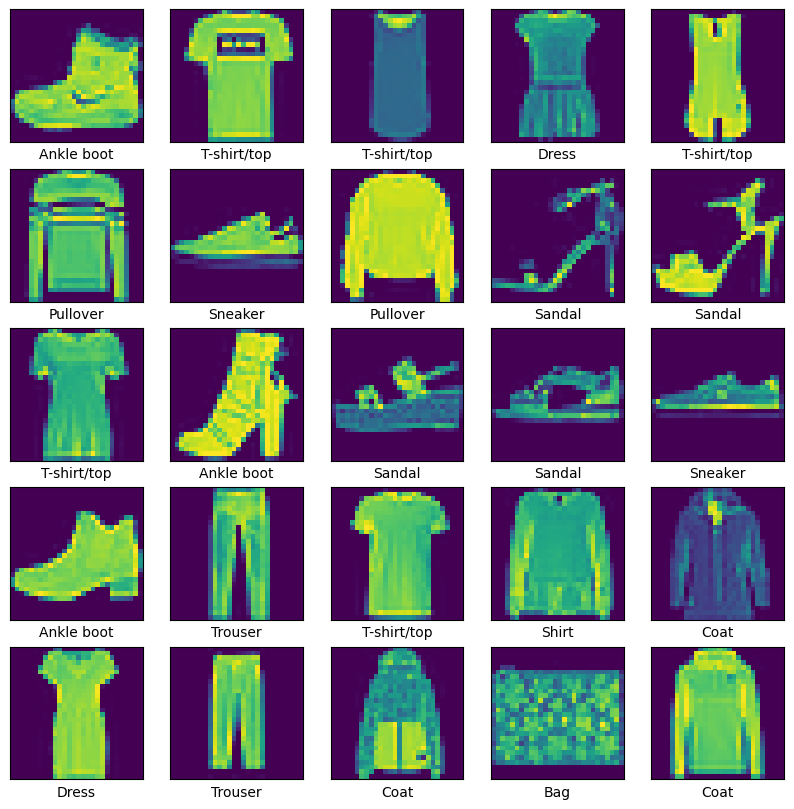

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [7]:
# preprocess images
x_train = x_train[:3000]
y_train = y_train[:3000]
x_test = x_test[:500]
y_test = y_test[:500]

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0

print('x_train shape:', x_train.shape, "y_train shape:", y_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (3000, 28, 28, 1) y_train shape: (3000,)
Number of images in x_train 3000
Number of images in x_test 500


In [8]:
model = models.alexnet(pretrained=True)
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 92.3MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

##AlexNet

In [9]:
model = Sequential()
model.add(Conv2D(64, (11, 11), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192, (5, 5),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(384, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [10]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=15,batch_size=16,steps_per_epoch=len(x_train)/32)


Epoch 1/15
93/93 [==============================] - 42s 421ms/step - loss: 2.1880 - accuracy: 0.1602
Epoch 2/15
93/93 [==============================] - 41s 435ms/step - loss: 1.7149 - accuracy: 0.3215
Epoch 3/15
93/93 [==============================] - 40s 422ms/step - loss: 1.2691 - accuracy: 0.5073
Epoch 4/15
93/93 [==============================] - 40s 427ms/step - loss: 0.9965 - accuracy: 0.6350
Epoch 5/15
93/93 [==============================] - 40s 419ms/step - loss: 0.8549 - accuracy: 0.6828
Epoch 6/15
93/93 [==============================] - 39s 416ms/step - loss: 0.7181 - accuracy: 0.7393
Epoch 7/15
93/93 [==============================] - 39s 421ms/step - loss: 0.7166 - accuracy: 0.7387
Epoch 8/15
93/93 [==============================] - 39s 416ms/step - loss: 0.6215 - accuracy: 0.7734
Epoch 9/15
93/93 [==============================] - 39s 417ms/step - loss: 0.5661 - accuracy: 0.7832
Epoch 10/15
93/93 [==============================] - 39s 416ms/step - loss: 0.5627 - accura

In [11]:
# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

16/16 [==============================] - 4s 250ms/step - loss: 0.5210 - accuracy: 0.8200
Train accuracy: 0.8650000095367432
Test accuracy: 0.8199999928474426


In [12]:
predictions = model.predict(x_test)

16/16 [==============================] - 3s 181ms/step


##Predictions visualization

In [13]:

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

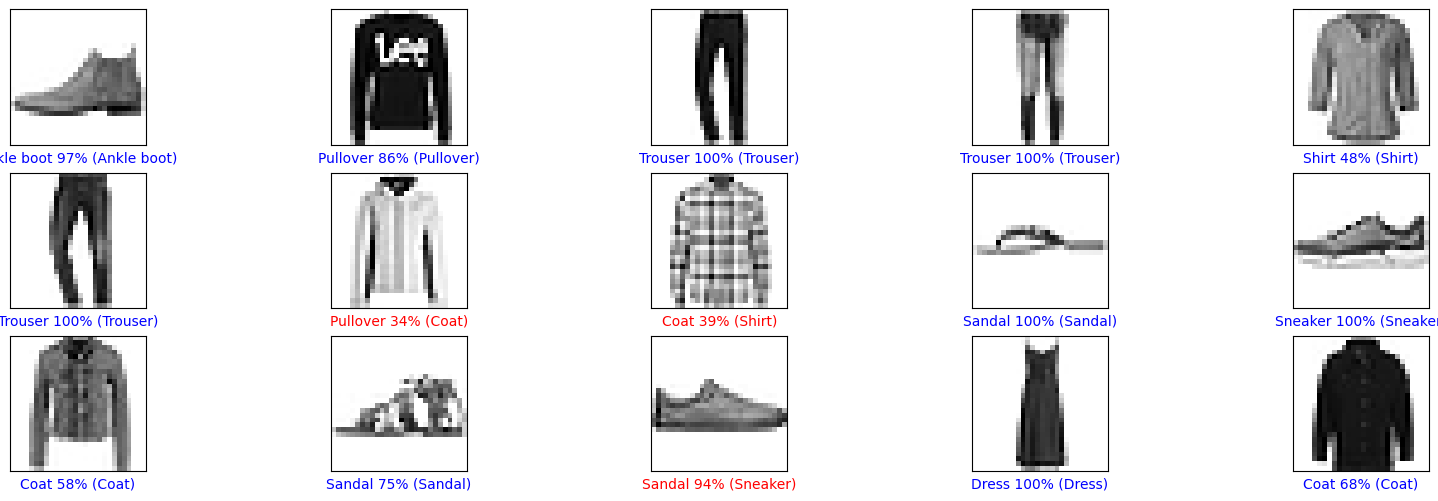

In [14]:

n_rows = 3
n_cols = 5
n_images = n_rows*n_cols
plt.figure(figsize=(2*2*n_cols, 2*n_rows))
for i in range(n_images):
  plt.subplot(n_rows, n_cols, i+1)
  plot_image(i, predictions, y_test, x_test)
plt.show()


##Siamese networks

In [33]:
data_train = pd.read_csv('drive/MyDrive/CV/fashion-mnist_train.csv')

# Extracting the input features and output labels from the dataframe
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [34]:
#Reshaping and scaling the input features for the model

x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [35]:
#Organizing the data into groups for the siamese network

train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4221, 4162, 4156, 4216, 4207, 4266, 4174, 4190, 4193, 4215]
test groups: [1779, 1838, 1844, 1784, 1793, 1734, 1826, 1810, 1807, 1785]


In [36]:
#Function to generate random batches of data for training the siamese network

def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]

    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

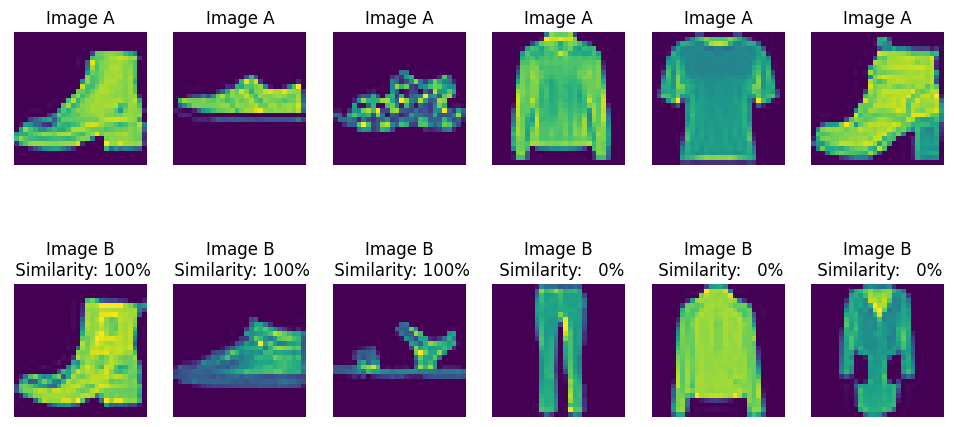

In [37]:
#Generating a random batch of data and plotting the images and their similarity scores

pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [38]:
# Define the input layer for the feature extraction model
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in

# Create convolutional layers for feature extraction
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)


# Flatten the output of the convolutional layers
n_layer = Flatten()(n_layer)

# Add fully connected layers for further feature extraction and reduction
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)

# Create the feature extraction model
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 batch_normalization_7 (Batc  (None, 26, 26, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_15 (Activation)  (None, 26, 26, 8)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_8 (Batc  (None, 24, 24,

In [39]:
# Define input layers for the two images to be compared
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

# Extract features from the two input images using the feature extraction model
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)

# Concatenate the extracted features
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')

# Add fully connected layers for classification
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)

# Create the similarity model
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [40]:
# Compile the similarity model with specified optimizer and loss function

similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

1/1 [==============================] - 1s 578ms/step


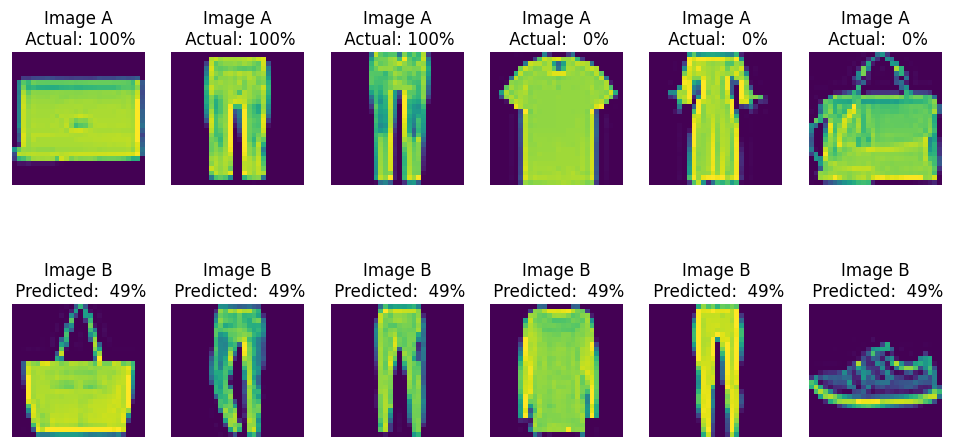

In [41]:
# Define a function to display the actual and predicted similarity scores for a given number of image pairs

def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# A completely untrained model
_ = show_model_output()

In [42]:
# Make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
                               steps_per_epoch = 250,
                                               epochs = 10,
                                             verbose = True)

Epoch 1/10
250/250 [==============================] - 30s 98ms/step - loss: 0.6962 - mae: 0.4711
Epoch 2/10
250/250 [==============================] - 27s 109ms/step - loss: 0.5834 - mae: 0.4251
Epoch 3/10
250/250 [==============================] - 27s 109ms/step - loss: 0.5319 - mae: 0.3864
Epoch 4/10
250/250 [==============================] - 24s 98ms/step - loss: 0.4882 - mae: 0.3495
Epoch 5/10
250/250 [==============================] - 25s 101ms/step - loss: 0.4709 - mae: 0.3296
Epoch 6/10
250/250 [==============================] - 26s 104ms/step - loss: 0.4542 - mae: 0.3144
Epoch 7/10
250/250 [==============================] - 25s 100ms/step - loss: 0.4376 - mae: 0.3016
Epoch 8/10
250/250 [==============================] - 25s 98ms/step - loss: 0.4326 - mae: 0.2949
Epoch 9/10
250/250 [==============================] - 26s 104ms/step - loss: 0.4134 - mae: 0.2806
Epoch 10/10
250/250 [==============================] - 29s 114ms/step - loss: 0.4176 - mae: 0.2782


1/1 [==============================] - 0s 28ms/step


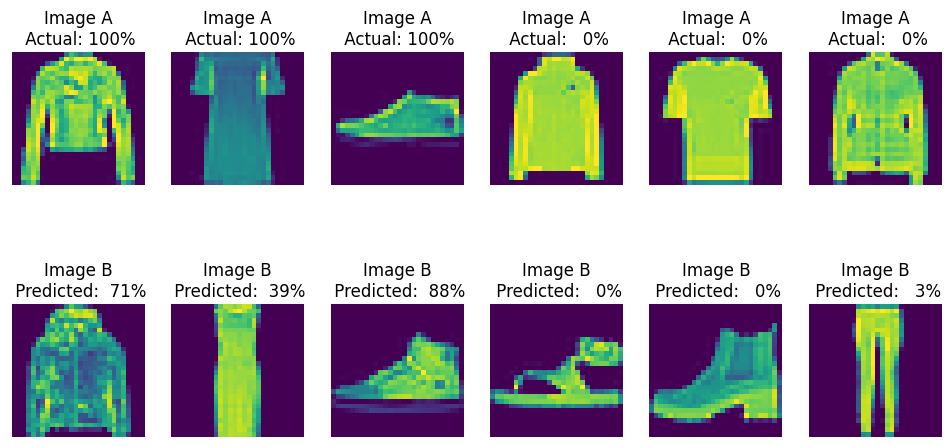

In [43]:
_ = show_model_output()

##Visualization with t-SNE

In [44]:
x_test_features = model.predict(x_test, verbose=True, batch_size=128)

141/141 [==============================] - 114s 809ms/step


In [45]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.026s...
[t-SNE] Computed neighbors for 18000 samples in 0.983s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

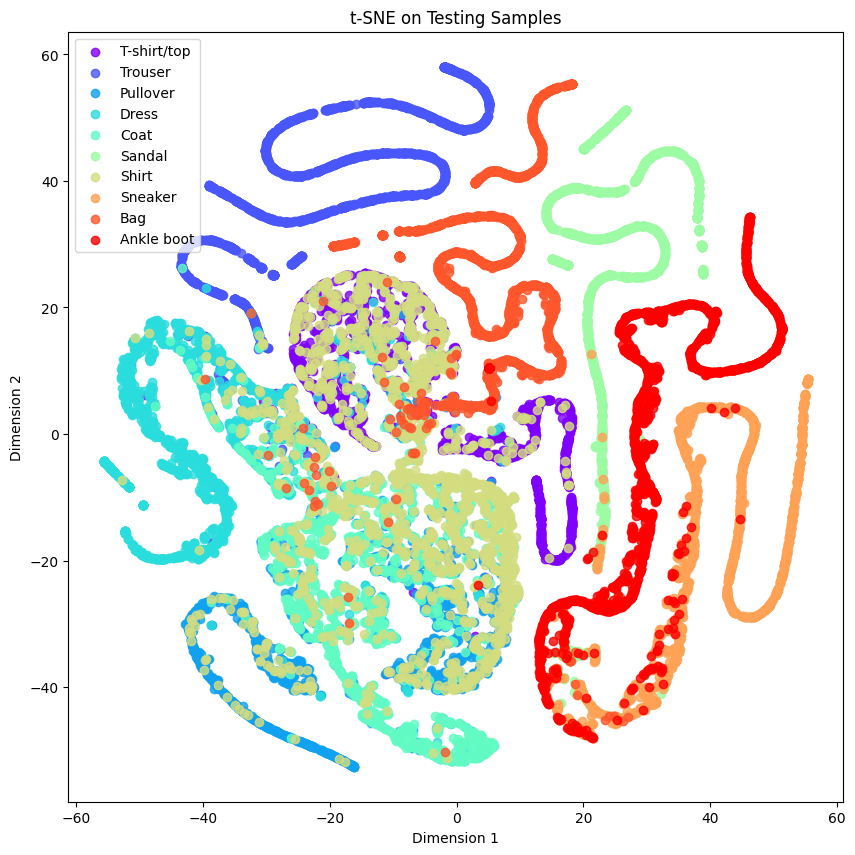

In [46]:
obj_categories = [
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)